# Disaster Data Analysis – Functions と Loop を使った可視化

この Notebook では、`emdat.csv` を用いて世界の災害データを分析する。  
課題要件である以下の 3 点を満たすことを目的とする。

1. 自作の Function（関数）
2. 関数を使ったサンプル出力
3. Loop（for 文）による複数グラフの可視化

最終的に、災害タイプごとの死亡者数の違いや年代ごとの傾向について考察する。


In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# =========================================
# 日本語フォント設定（Windows）
#   → あなたの PC にある Yu Gothic を使用
# =========================================
font_path = r"C:\Windows\Fonts\YuGothM.ttc"  # さっき確認したパス
fm.fontManager.addfont(font_path)
jp_font = fm.FontProperties(fname=font_path)

plt.rcParams["font.family"] = jp_font.get_name()
plt.rcParams["axes.unicode_minus"] = False  # マイナス記号の文字化け防止

print("使用フォント:", plt.rcParams["font.family"])


使用フォント: ['Yu Gothic']


In [54]:
# =========================================
# CSV 読み込み
# =========================================
df = pd.read_csv("emdat.csv")

# 欠損値があると集計がややこしくなるので、とりあえず 0 で埋める
df["Total Deaths"] = df["Total Deaths"].fillna(0)

# 災害タイプを日本語に変換する辞書
type_jp = {
    "Flood": "洪水", "Earthquake": "地震", "Epidemic": "感染症",
    "Drought": "干ばつ", "Storm": "嵐", "Volcanic activity": "火山活動",
    "Wildfire": "山火事", "Extreme temperature": "異常気温",
    "Mass movement (dry)": "地すべり（乾燥）",
    "Mass movement (wet)": "地すべり（湿潤）",
    "Infestation": "害虫被害",
    "Impact": "衝突災害",
    "Animal incident": "動物被害",
    "Fog": "濃霧",
    "Glacial lake outburst flood": "氷河湖決壊洪水"
}

# 新しい列「災害タイプ」を作る
df["災害タイプ"] = df["Disaster Type"].replace(type_jp)

# 年代ごとの集計に使うための列も作っておく（例：1993→1990）
df["Decade"] = (df["Start Year"] // 10) * 10

df.head()


,Disaster Subgroup,Disaster Type,Disaster Subtype,ISO,Country,Subregion,Region,Latitude,Longitude,Start Year,Total Deaths,災害タイプ,Decade
0,Meteorological,Storm,Tropical cyclone,USA,United States of America,Northern America,Americas,NaN,NaN,1900,6000.0,嵐,1900
1,Hydrological,Flood,Flood (General),JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,300.0,洪水,1900
2,Biological,Epidemic,Viral disease,JAM,Jamaica,Latin America and the Caribbean,Americas,NaN,NaN,1900,30.0,感染症,1900
3,Geophysical,Volcanic activity,Ash fall,JPN,Japan,Eastern Asia,Asia,NaN,NaN,1900,30.0,火山活動,1900
4,Geophysical,Earthquake,Ground movement,TUR,Türkiye,Western Asia,Asia,40.3,43.1,1900,140.0,地震,1900


## 1. 関数の作成

まず、「災害タイプを指定すると、その災害が原因で死亡した人数の合計を返す関数」を作成する。


In [55]:
# =========================================
# 関数定義：災害タイプ別の総死亡者数
# =========================================
def total_deaths_by_type(dataframe, dtype):
    """
    引数:
        dataframe : pandas DataFrame（emdat データ）
        dtype     : 日本語の災害タイプ名（例："洪水", "地震"）
    戻り値:
        指定した災害タイプの総死亡者数（float）
    """
    sub = dataframe[dataframe["災害タイプ"] == dtype]
    return sub["Total Deaths"].sum()


In [56]:
# =========================================
# 関数を使ってサンプル出力
# =========================================
for sample_type in ["洪水", "地震", "干ばつ", "感染症"]:
    total = total_deaths_by_type(df, sample_type)
    print(f"{sample_type} の総死亡者数: {total:,.0f}")


洪水 の総死亡者数: 7,016,630
地震 の総死亡者数: 2,409,975
干ばつ の総死亡者数: 11,734,272
感染症 の総死亡者数: 9,623,111


## 2. Loop を使った複数グラフの可視化

for 文を用いて、災害タイプごとに「年間死亡者数の推移」の折れ線グラフを自動で作成する。  
全ての災害タイプを一つずつ手で描くのではなく、Loop でまとめて描画する点がポイントである。


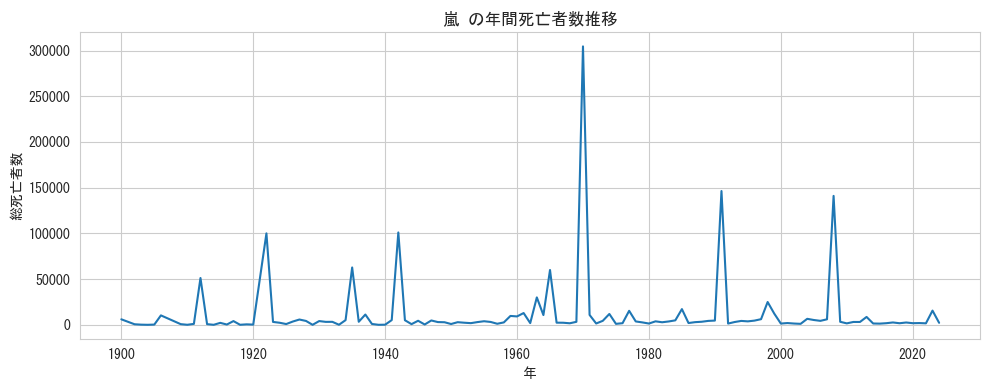

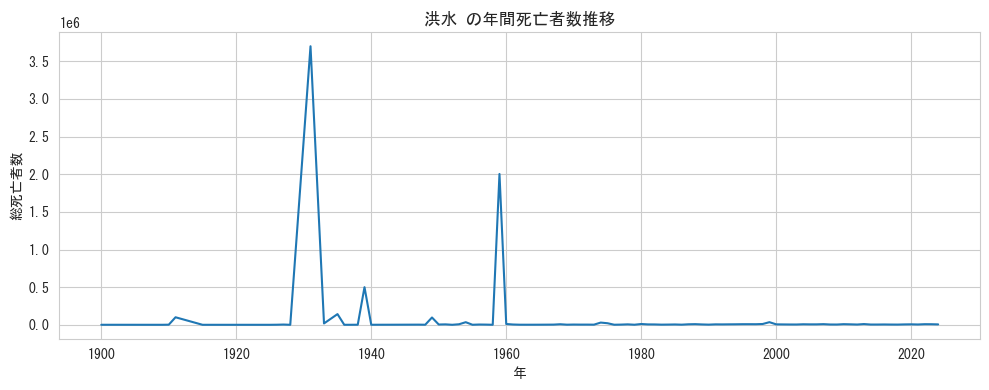

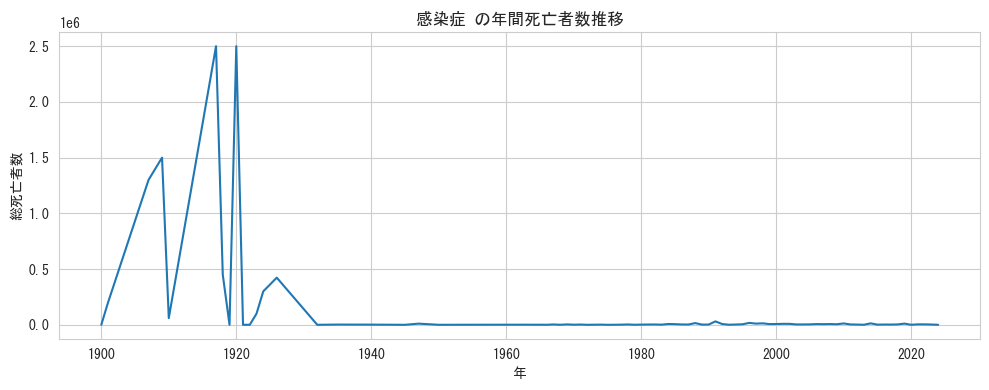

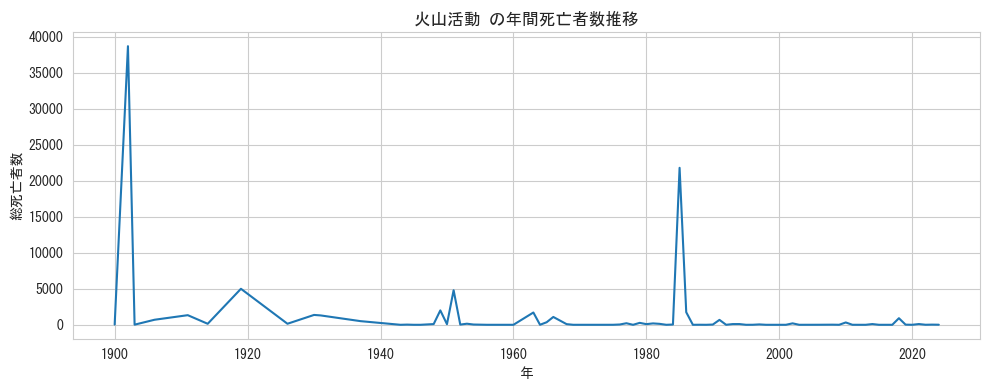

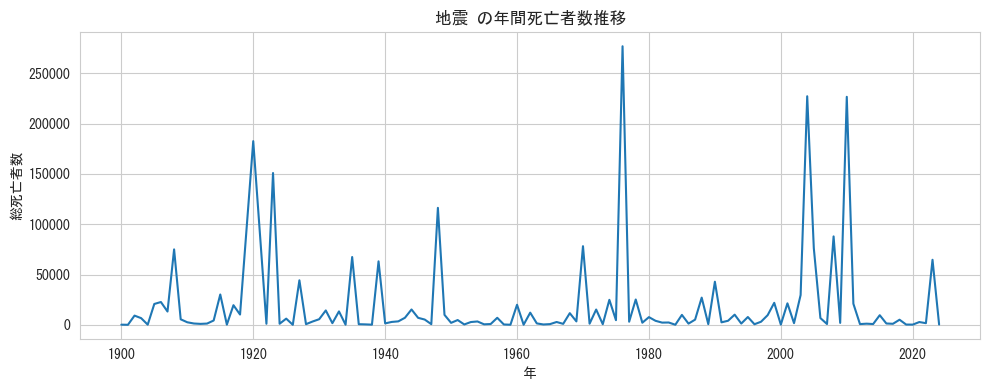

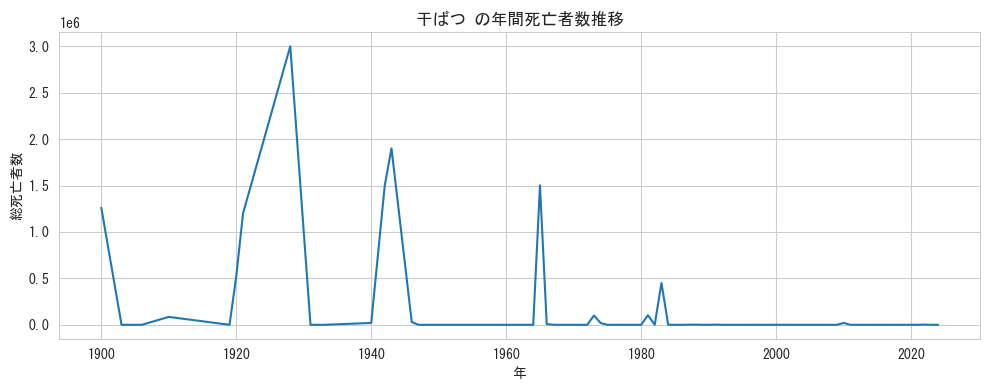

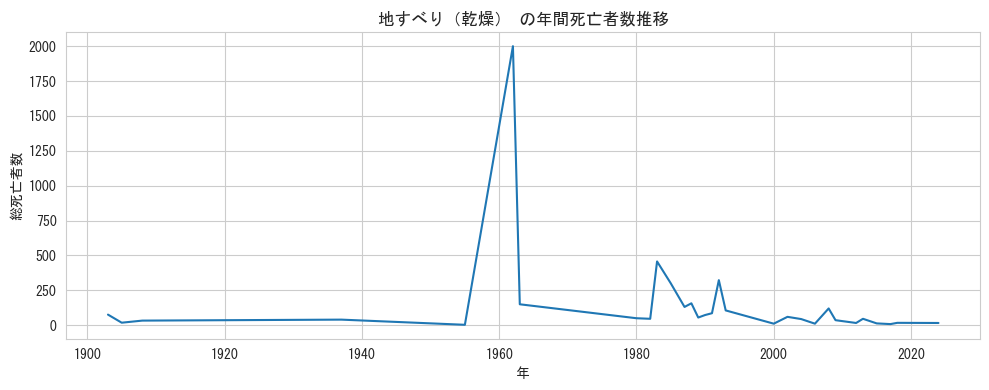

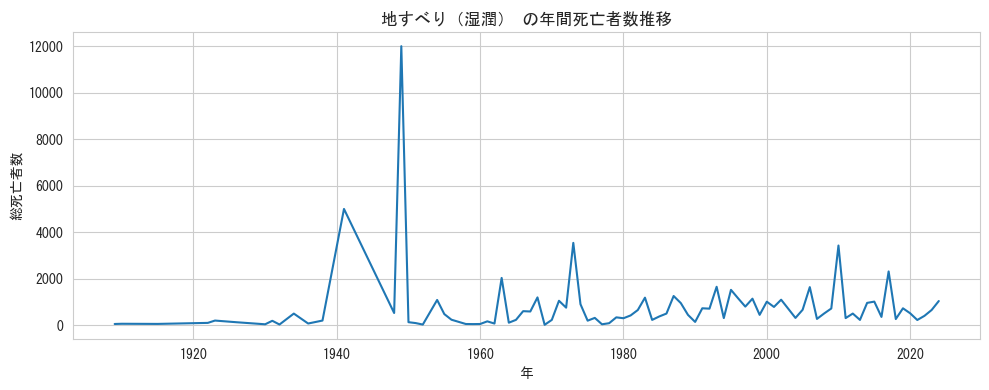

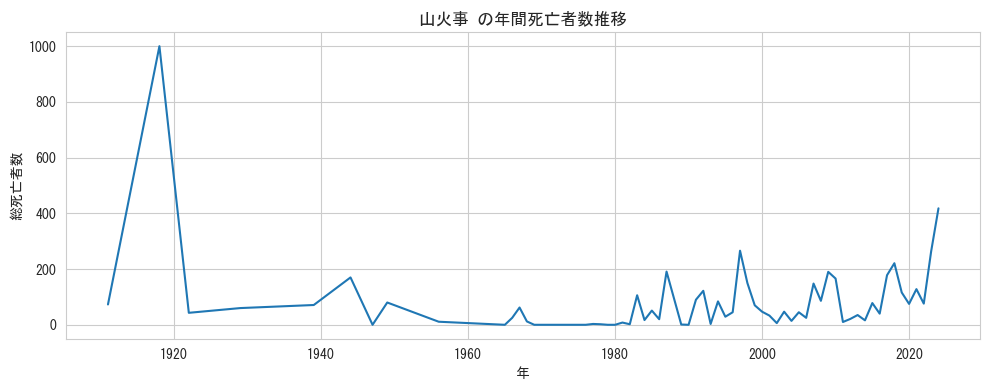

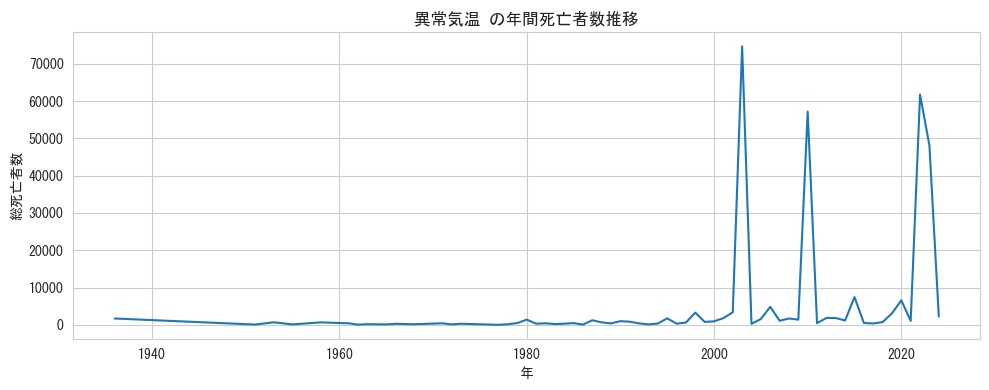

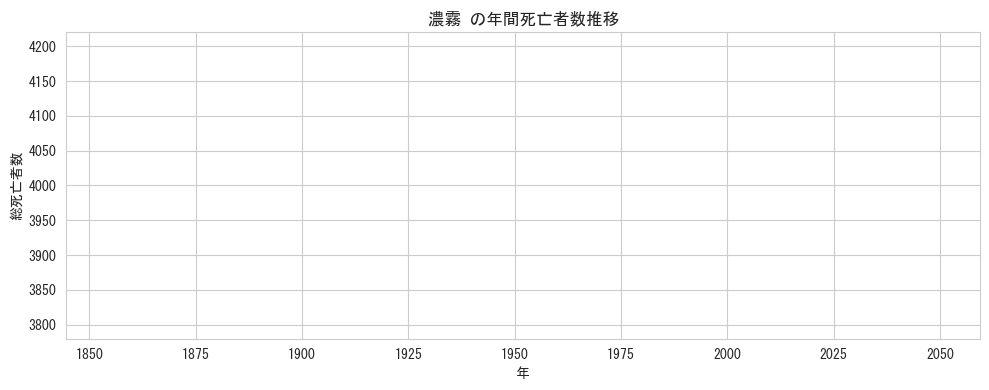

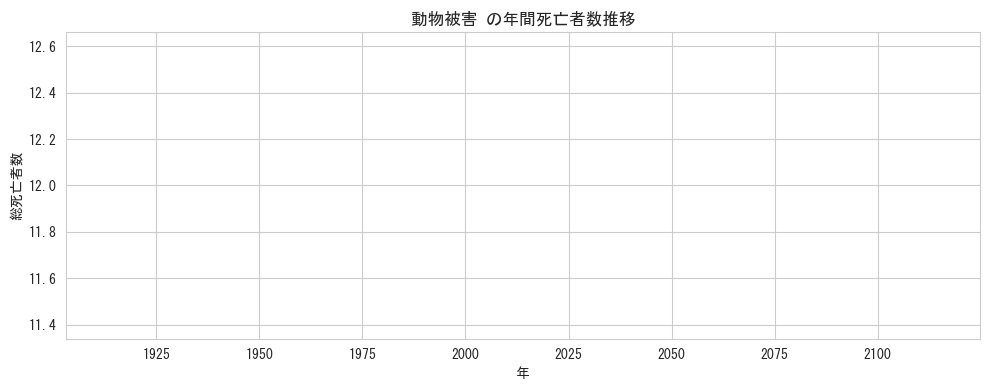

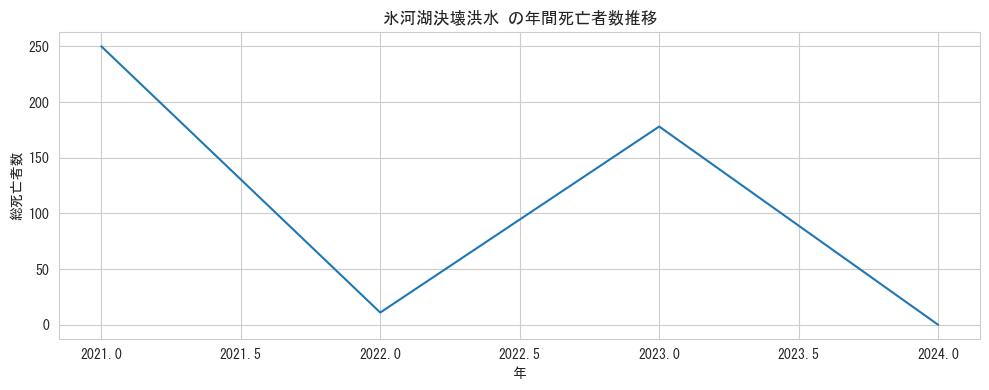

In [61]:
# =========================================
# 災害タイプごとの年間死亡者数推移を for 文で一気に描画
# =========================================
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'MS Gothic'   # Windowsならこれが最適

disaster_types = df["災害タイプ"].unique()

for dtype in disaster_types:
    subset = df[df["災害タイプ"] == dtype]
    yearly = subset.groupby("Start Year")["Total Deaths"].sum()

    # データがほぼ 0 のものはスキップしてもよい（お好みで）
    if yearly.sum() == 0:
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(yearly.index, yearly.values)
    plt.title(f"{dtype} の年間死亡者数推移")
    plt.xlabel("年")
    plt.ylabel("総死亡者数")
    plt.tight_layout()
    plt.show()


## 3. 災害別総死亡者数ランキング

次に、災害タイプごとの総死亡者数を合計し、値が大きい順に並べたランキングを作る。  
日本語表示と見やすさを意識して、横棒グラフ（barh）で上位 10 種類を可視化する。


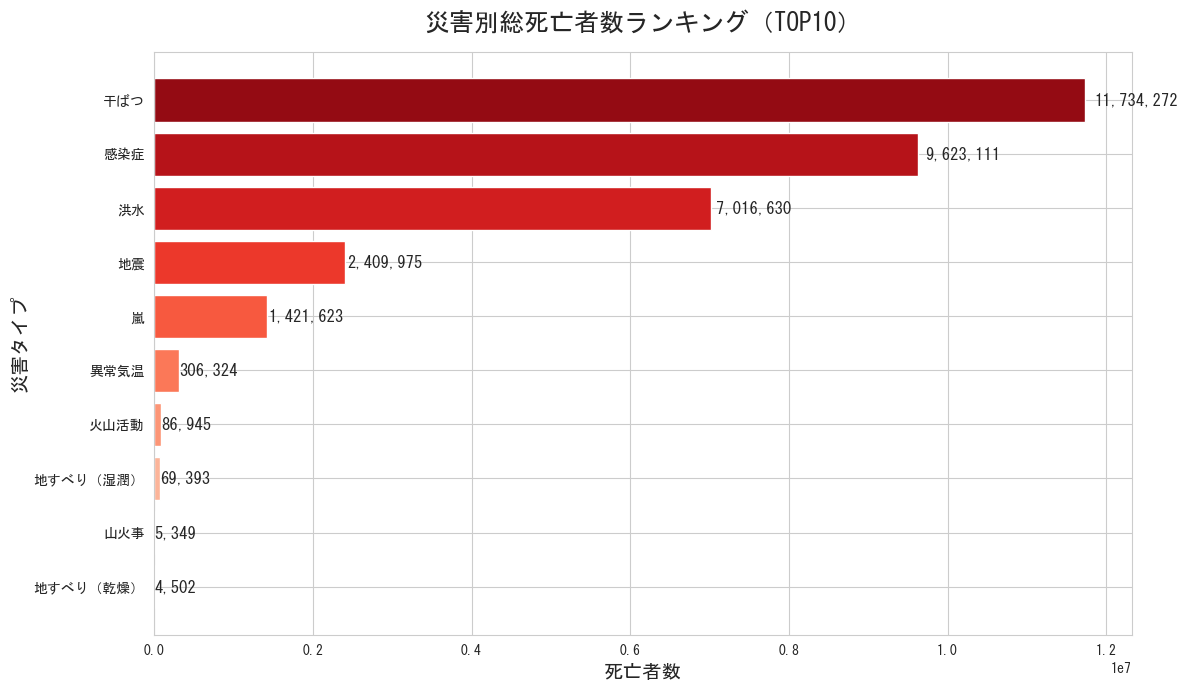

In [62]:
# =========================================
# 災害別死亡者数ランキング TOP10（横棒グラフ）
# =========================================
death_by_type = (
    df.groupby("災害タイプ")["Total Deaths"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(12, 7))
colors = sns.color_palette("Reds", len(death_by_type))[::-1]

bars = plt.barh(death_by_type.index, death_by_type.values, color=colors)

# 数値ラベルを棒の右側に描画
for bar in bars:
    width = bar.get_width()
    plt.text(
        width * 1.01,                               # ほんの少し右側
        bar.get_y() + bar.get_height() / 2,
        f"{int(width):,}",
        va="center",
        fontsize=12
    )

plt.title("災害別総死亡者数ランキング（TOP10）", fontsize=18, pad=15)
plt.xlabel("死亡者数", fontsize=14)
plt.ylabel("災害タイプ", fontsize=14)
plt.gca().invert_yaxis()  # 1位を上に
plt.tight_layout()
plt.show()


### （オプション）年代 × 災害タイプ別の死亡者ヒートマップ

年代ごとの合計死亡者数を災害別に並べ、ヒートマップで可視化することで、  
「どの年代にどの災害が目立っていたか」を一目で確認できる。


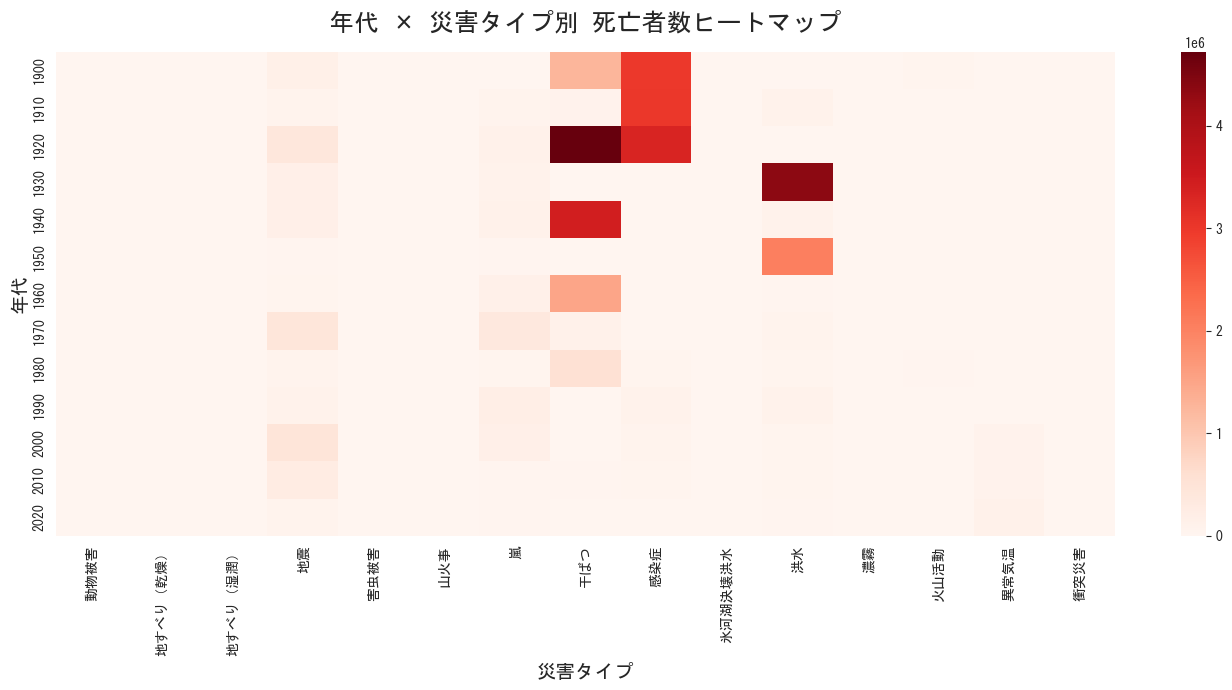

In [63]:
# =========================================
# 年代 × 災害タイプ別死亡者数ヒートマップ
# =========================================
pivot = df.pivot_table(
    index="Decade",
    columns="災害タイプ",
    values="Total Deaths",
    aggfunc="sum"
).fillna(0)

plt.figure(figsize=(14, 7))
sns.heatmap(pivot, cmap="Reds")
plt.title("年代 × 災害タイプ別 死亡者数ヒートマップ", fontsize=18, pad=15)
plt.xlabel("災害タイプ", fontsize=14)
plt.ylabel("年代", fontsize=14)
plt.tight_layout()
plt.show()


## 4. 考察

今回の分析から、災害タイプごとに死亡者数の規模や時間的な傾向には大きな違いがあることが分かった。

- 「干ばつ」「感染症」「洪水」「地震」などは、総死亡者数が特に多く、世界の災害死亡の大部分を占めている。
- グラフからは、特定の年・年代にピークが集中している災害も多く見られ、単発の大規模災害が統計全体に強く影響している可能性が示唆される。
- 一方、「動物被害」「濃霧」「衝突災害」などの災害は、長期的に見ると死亡者数が少なく、発生頻度も限られていると考えられる。

総じて、災害リスクを評価する際には、「どの災害がどれくらいの頻度で、どれくらいの被害規模をもたらしているか」を
定量的に把握した上で、優先度の高い災害から対策を行う必要があると考えられる。
